# COMP0005 - GROUP COURSEWORK
# Experimental Evaluation of Search Data Structures and Algorithms

The cell below defines **AbstractSearchInterface**, an interface to support basic insert/search operations; you will need to implement this three times, to realise your three search data structures of choice among: (1) *2-3 Tree*, (2) *AVL Tree*, (3) *LLRB BST*; (4) *B-Tree*; and (5) *Scapegoat Tree*. <br><br>**Do NOT modify the next cell** - use the dedicated cells further below for your implementation instead. <br>

In [184]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractSearchInterface(ABC):
    '''
    Abstract class to support search/insert operations (plus underlying data structure)
    
    '''
        
    @abstractmethod
    def insertElement(self, element):     
        '''
        Insert an element in a search tree
            Parameters:
                    element: string to be inserted in the search tree (string)

            Returns:
                    "True" after successful insertion, "False" if element is already present (bool)
        '''
        
        pass 
    

    @abstractmethod
    def searchElement(self, element):
        '''
        Search for an element in a search tree
            Parameters:
                    element: string to be searched in the search tree (string)

            Returns:
                    "True" if element is found, "False" otherwise (bool)
        '''

        pass

Use the cell below to define any auxiliary data structure and python function you may need. Leave the implementation of the main API to the next code cells instead.

In [185]:
# ADD AUXILIARY DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE

from math import log


def mean(nums):
    length = len(nums)

    if length == 0:
        raise ValueError("Mean cannot be computed on an empty list")

    return sum(nums) / length


def median(nums):
    length = len(nums)

    sorted_nums = sorted(nums)

    if length % 2 == 1:
        return sorted_nums[length // 2]
    else:
        return (sorted_nums[length // 2 - 1] + sorted_nums[length // 2]) / 2


def sliding_window_average(nums, window_size=5):
    # Applies a smoothing filter on nums, based on a sliding window
    length = len(nums)

    averages = []
    for i in range(length):
        window_left = max(0, round(i - window_size / 2))
        window_right = min(length, round(i + window_size / 2))

        averages.append(mean(nums[window_left:window_right]))
    
    return averages


def line_of_best_fit(xs, ys):
    """
    Given two equally long lists of numbers [x1, x2, ...] and [y1, y2, ...], computes the line of best fit y = mx+c for the points (x1, y1), (x2, y2), ... using the least square method. Returns m and c.

    Based on https://www.geeksforgeeks.org/least-square-method/ and https://en.wikipedia.org/wiki/Ordinary_least_squares#Simple_linear_regression_model.
    """
    x_avg = mean(xs)
    y_avg = mean(ys)

    m = sum([(x - x_avg)*(y - y_avg) for (x,y) in zip(xs, ys)]) / sum([(x - x_avg)**2 for x in xs])

    c = y_avg - m * x_avg

    return m, c


def log_curve_of_best_fit(xs, ys):
    """
    Given two equally long lists of numbers [x1, x2, ...] and [y1, y2, ...], computes the logarithmic curve of best fit y = a log(x) + b for the points (x1, y1), (x2, y2), ... using the least square method. Returns a and b.

    Here, "log" refers to the natural logarithm (base e). The list xs must not contain zero.

    Based on https://stackoverflow.com/a/3433503.
    """

    # To fit y = a log(x) + b, we compute the line of best fit for y and log(x).

    return line_of_best_fit(list(map(log, xs)), ys)


def format_float_for_matplotlib_latex(x):
    string = str(x)

    if 'e' not in string:
        return string
    
    base, exponent = str(x).split('e')

    exponent = int(exponent)
    base = round(float(base), 3)

    return f"{base} \\times 10^{-exponent}"

Use the cell below to implement the requested API by means of **2-3 Tree** (if among your chosen data structure).

In [186]:
class TwoThreeNode:
    def __init__(self, keys, parent = None):
        self.keys = list([keys]) #ensures that "keys" is always a list, even when setting it to a single element
        self.parent = parent #a single Node
        self.children = [] #list of child Nodes

    def isLeaf(self):
        return len(self.children) == 0
    
    def searchElement(self, key):
        found = False

        #base case: found the key
        if key in self.keys:
            found = True
            print(f"Key: {key} found!")
            return found
        
        #base case: couldn't find the key and reached the end of the tree
        elif self.isLeaf():
            print(f"Key: {key} was not found")
            return found #false
        
        elif key < self.keys[0]:#key is less than everything in the node, so recursively search left child
            return self.children[0].searchElement(key)
        elif key > self.keys[-1]: # key is more than everything in the node, so search right child
            return self.children[-1].searchElement(key)
        else: #this should only be reached when encountering a 3-node, and the value of "key" is between the keys in the node
            return self.children[1].searchElement(key)


    def insertElement(self, node):
        inserted = False

        if self.isLeaf():
            if node.keys[0] in self.keys:
                return inserted #false
            else:
                self.addNode(node)
                inserted = True
                print(f"{node.keys[0]} was inserted!")
                return inserted

        elif node.keys[0] < self.keys[0]:  # key is less than everything in the node, so recursively search left child
            return self.children[0].insertElement(node)
        elif node.keys[0] > self.keys[-1]:  # key is more than everything in the node, so search right child
            return self.children[-1].insertElement(node)
        else:  # this should only be reached when encountering a 3-node, and the value of "key" is between the keys in the node
            return self.children[1].insertElement(node)


    def addNode(self, node):
        #necessary for when dealing with 4-nodes (see below)
        for child in node.children:
            child.parent = self

        self.keys.extend(node.keys)
        self.keys.sort()
        self.children.extend(node.children)
        
        if len(self.children) > 1:
            self.children.sort(key=lambda node: node.keys) #Because children is a list of "nodes", must specify that we sort by the keys
        if len(self.keys) > 2:
            self.splitNode()
    
    #splitting a 4-node
    def splitNode(self):
        """
        NOTES:
        - self = Originally the middle key of the 4-node, it merges with the parent above it
        - leftChild = Originally the left key of the 4-node, it becomes a child of "self"
        - rightChild = Originally the right key of the 4-node, it also becomes a child of "self"
        """

        leftChild = TwoThreeNode(self.keys[0], self) #make "self" the parent because we are going to move the middle element up to create a new layer
        rightChild = TwoThreeNode(self.keys[2], self)

        #must check this because we could have created a 4-node that is also a leaf
        if self.children != []:
            #if the 4-node has children, then it must have exactly 4 of them, so:
            self.children[0].parent = leftChild
            self.children[1].parent = leftChild
            self.children[2].parent = rightChild
            self.children[3].parent = rightChild
            leftChild.children = [self.children[0], self.children[1]]
            rightChild.children = [self.children[2], self.children[3]]

        self.children = [leftChild, rightChild]
        self.keys = [self.keys[1]]

        if self.parent:
            if self in self.parent.children:
                self.parent.children.remove(self) #remove "self" from the list of children because we are merging "self" and its former parent
            self.parent.addNode(self) #recursively go up the tree until there are no 4-nodes
        else:
            leftChild.parent = self
            rightChild.parent = self

class TwoThreeTree(AbstractSearchInterface):
    def __init__(self):
        self.root = None

    def insertElement(self, key):
        if self.root == None:
            self.root = TwoThreeNode(key)
            print(f"{key} was inserted as a root!")
            return True
        else:
            node = TwoThreeNode(key)
            inserted = self.root.insertElement(node)

            #this is in case splitting the node creates a new root. just ensures that the root always has the correct assignment
            while self.root.parent:
                self.root = self.root.parent

            return inserted
        

    def searchElement(self, key):
        return self.root.searchElement(key)

Use the cell below to implement the requested API by means of **AVL Tree** (if among your chosen data structure).

In [187]:
class AVLTree(AbstractSearchInterface):
        
    def insertElement(self, element):
        inserted = False
        # ADD YOUR CODE HERE
      
        
        return inserted
    
    

    def searchElement(self, element):     
        found = False
        # ADD YOUR CODE HERE

        
        return found  

Use the cell below to implement the requested API by means of **LLRB BST** (if among your chosen data structure).

In [188]:
class RedBlackNode:
    RED = True
    BLACK = False

    def __init__(self, key, colour=RED):
        self.key = key
        self.colour = colour
        self.left = None
        self.right = None


class LLRBBST(AbstractSearchInterface):
    def __init__(self):
        self.root = None

    def isRed(self, node):
        return node is not None and node.colour == RedBlackNode.RED

    def searchElement(self, key):
        found = False
        current = self.root
        while current:
            if key < current.key:
                current = current.left
            elif key > current.key:
                current = current.right
            elif key == current.key:
                found = True
                break
        return found

    def insertElement(self, element):
        inserted = False  # Start as False
        if not self.searchElement(element):  # If element does not exist
            self.root = self.insert(self.root, element)
            if self.root:
                self.root.colour = RedBlackNode.BLACK  # Ensure the root is always black
            inserted = True  # Set to True only when insertion occurs

        return inserted  # True if insertion was successful, False otherwise

    def insert(self, node, key):
        # Standard BST insert
        if not node:
            return RedBlackNode(key, RedBlackNode.RED)

        if key < node.key:
            node.left = self.insert(node.left, key)
        elif key > node.key:
            node.right = self.insert(node.right, key)

        # Balance the tree
        # Case 1: Right child red, left child black -> Rotate left
        if self.isRed(node.right) and not self.isRed(node.left):
            node = self.rotateLeft(node)

        # Case 2: Left child and left-left grandchild red -> Rotate right
        if self.isRed(node.left) and self.isRed(node.left.left):
            node = self.rotateRight(node)

        # Case 3: Both children red -> Flip colors
        if self.isRed(node.left) and self.isRed(node.right):
            self.flipColour(node)

        # Continue propagating corrections upward
        if self.isRed(node.right) and not self.isRed(node.left):
            node = self.rotateLeft(node)

        if self.isRed(node.left) and self.isRed(node.left.left):
            node = self.rotateRight(node)

        return node

    def rotateLeft(self, node):
        if not node or not node.right:  # Safety check
            return node

        x = node.right
        node.right = x.left
        x.left = node
        x.colour = node.colour
        node.colour = RedBlackNode.RED
        return x

    def rotateRight(self, node):
        if not node or not node.left:  # Safety check
            return node

        x = node.left
        node.left = x.right
        x.right = node
        x.colour = node.colour
        node.colour = RedBlackNode.RED
        return x

    def flipColour(self, node):
        if node and node.left and node.right:  # Safety check
            node.colour = RedBlackNode.RED
            node.left.colour = RedBlackNode.BLACK
            node.right.colour = RedBlackNode.BLACK

Use the cell below to implement the requested API by means of **B-Tree** (if among your chosen data structure).

In [189]:
class BTree(AbstractSearchInterface):
        
    def insertElement(self, element):
        inserted = False
        # ADD YOUR CODE HERE
      
        
        return inserted
    
    

    def searchElement(self, element):     
        found = False
        # ADD YOUR CODE HERE

        
        return found

Use the cell below to implement the requested API by means of **Scapegoat Tree** (if among your chosen data structure).

In [190]:
class ScapegoatTree(AbstractSearchInterface):
        
    def insertElement(self, element):
        inserted = False
        # ADD YOUR CODE HERE
      
        
        return inserted
    
    

    def searchElement(self, element):     
        found = False
        # ADD YOUR CODE HERE

        
        return found 

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (be mindful of code readability and reusability).

In [191]:
from string import ascii_lowercase
from random import shuffle, choice


class TestDataGenerator:
    """
    A class to represent a synthetic data generator.
    """

    def __init__(self):
        pass  # No attributes here

    def strings_in_order_generator(self, start_from_len=1):
        """
        Returns a generator that yields the following strings in alphabetical order:

            a, b, c, ..., z,
            aa, ab, ac, ..., az,
            ba, bb, bc, ..., bz,
            ...

        There is no limit as to how many strings this generator can yield.

        The optional parameter start_from_len (defaults to 1) determines the length of the first string yielded.
        If (e.g.) start_from_len == 4, then the generator yields the following in order:

            aaaa, aaab, aaac, ...

        Example usage:

            gen = TestDataGenerator().strings_in_order_generator()

            for i in range(100):
                print(next(gen))
        """

        string = "a" * start_from_len
        length = start_from_len

        while True:
            yield string

            str_reverse = string[::-1]

            new_str_reverse = ""

            i = 0
            while i < length and str_reverse[i] == "z":
                new_str_reverse += "a"
                i += 1

            if i == length:
                new_str_reverse += "a"
                length += 1
            else:
                new_str_reverse += chr(ord(str_reverse[i]) + 1) + str_reverse[i + 1:]

            string = new_str_reverse[::-1]

    def strings_in_reverse_order_generator(self, start_from_len):
        """
        Returns a generator that yields strings in reverse alphabetical order, starting with a string that consists of the character "z" repeated [start_from_len] times.

        The following example has start_from_len == 2:

            zz, zy, zx, ..., za,
            yz, yy, yx, ..., ya,
            ...
            az, ay, ax, ..., aa,
            z, y, x, ..., a

        The generator can no longer yield after "a" has been yielded.

        Example usage:

            gen = TestDataGenerator().strings_in_reverse_order_generator(2)

            while True:
                next_string = next(gen, None)  # None is the default value for when no more string is yielded
                if next_string is None:
                    break
                print(next_string)
        """

        string = "z" * start_from_len
        length = start_from_len

        while True:
            yield string

            str_reverse = string[::-1]
            new_str_reverse = ""

            i = 0
            while i < length and str_reverse[i] == "a":
                new_str_reverse += "z"
                i += 1

            if i == length:
                if length == 1:
                    break

                length -= 1
                string = "z" * length
            else:
                new_str_reverse += chr(ord(str_reverse[i]) - 1) + str_reverse[i + 1:]
                string = new_str_reverse[::-1]

    def strings_in_random_order_generator(self, n, length):
        """
        Returns a generator yielding n distinct strings of identical length in a random order.

        Example usage:

            print(TestDataGenerator().distinct_strings_in_random_order_list(5))

        This may print something like:

            ['aae', 'aac', 'aaa', 'aab', 'aad']

        Note that for the strings to be distinct, n cannot be greater than 26 ** length (by combinatorics and pigeonhole principle). If this occurs, a ValueError will be raised.
        """

        if n > 26 ** length:
            raise ValueError(f"It is impossible to generate {n} distinct strings each of length {length}.")

        gen = self.strings_in_order_generator(start_from_len=length)

        result = []
        for _ in range(n):
            result.append(next(gen))

        shuffle(result)

        for string in result:
            yield string

    def random_string(self, length):
        return "".join([choice(ascii_lowercase) for _ in range(length)])

Use the cell below to implement the requested **experimental framework** (be mindful of code readability and reusability).

In [192]:
import timeit
import matplotlib.pyplot as plt
from random import choice

# Constants
ALPHABETICAL = 0
REVERSE_ALPHABETICAL = 1
RANDOM = 2
ALPHABETICALLY_BEFORE = 3
ALPHABETICALLY_AFTER = 4
INSERTED_FIRST = 5
INSERTED_LAST = 6
NON_EXISTING = 7


class ExperimentalFramework:
    def __init__(self, min_n=0, max_n=50):
        """
        All search and insert tests require a pre-condition where the tree in question already contains n elements.
        The attribute max_n defines the upper limit for n values in tests (min_n <= n < max_n).
        """
        self.min_n = min_n
        self.max_n = max_n

        # Variables to be used during insertion/search tests
        self.tree = None  # Tree object
        self.elements_inserted = []  # Elements inserted into the tree so far

        # Used to synthesise string data
        self.test_data_generator = TestDataGenerator()

    def get_generator_from_tree_ordering(self, tree_ordering: int, string_len: int = 10):
        """
        Returns a generator object corresponding the tree_ordering specified, which can either be:
        ALPHABETICAL, REVERSE_ALPHABETICAL or RANDOM.

        The string_len parameter, specifying the length of strings, is optional and defaults to 10.
        """

        if tree_ordering == ALPHABETICAL:
            return self.test_data_generator.strings_in_order_generator(start_from_len=string_len)
        elif tree_ordering == REVERSE_ALPHABETICAL:
            return self.test_data_generator.strings_in_reverse_order_generator(start_from_len=string_len)
        else:  # RANDOM
            return self.test_data_generator.strings_in_random_order_generator(n=self.max_n+1, length=string_len)

    def insertion_test(self, tree_type: type, tree_ordering, new_element_ordering, num_of_tests=100, smooth_with_window_size=None):
        """
        Runs [num_of_test] insertion operations for each n from min_n to (self.max_n - 1), inclusively.

        Parameters:
        - tree_type: A class that implements AbstractSearchInterface
        - tree_ordering: ALPHABETICAL, REVERSE_ALPHABETICAL or RANDOM
        - new_element_ordering: ALPHABETICALLY_BEFORE, ALPHABETICALLY_AFTER, or RANDOM

        An insertion test assumes a pre-condition where the tree has n elements inserted in the order specified by
        [tree_ordering].

        A new element, determined by [new_element_ordering] is then inserted. The time taken for insertion is measured.
        """

        string_len = 10

        # --------------------------------------------------------------------------------------------------------------

        def setup(num_of_elements):
            # Start by flushing the cache
            # Avoid smaller trees from being cached, which may skew results
            # Cache is flushed via large memory allocation
            _ = [0] * 10**7

            self.tree = tree_type()
            generator = self.get_generator_from_tree_ordering(tree_ordering, string_len)
            for _ in range(num_of_elements):
                self.tree.insertElement(next(generator))

        if new_element_ordering == ALPHABETICALLY_BEFORE:
            def insert():
                self.tree.insertElement("")  # Guaranteed to be alphabetically before
        elif new_element_ordering == ALPHABETICALLY_AFTER:
            def insert():
                self.tree.insertElement("z" * (string_len+1))   # Guaranteed to be alphabetically after
        else:  # RANDOM
            def insert():
                # Assume the randomly generated string is not already in the tree
                # (The probability of this occurring is very low)
                self.tree.insertElement(self.test_data_generator.random_string(string_len))

        return self.get_median_performance_for_each_tree_size(setup, insert, num_of_tests, smooth_with_window_size=smooth_with_window_size)

    def search_test(self, tree_type: type, tree_ordering, new_element_property, num_of_tests=100, smooth_with_window_size=None):
        """
        Runs [num_of_test] insertion operations for each n from self.min_n to (self.max_n - 1), inclusively.

        Parameters:
        - tree_type: A class that implements AbstractSearchInterface
        - tree_ordering: ALPHABETICAL, REVERSE_ALPHABETICAL or RANDOM
        - new_element_property: INSERTED_FIRST, INSERTED_LAST, RANDOM or NON_EXISTING

        An insertion test assumes a pre-condition where the tree has n elements inserted in the order specified by
        [tree_ordering].

        A new element, determined by [new_element_ordering] is then inserted. The time taken for insertion is measured.
        """

        string_len = 10
        generator = self.get_generator_from_tree_ordering(tree_ordering, string_len)

        # --------------------------------------------------------------------------------------------------------------

        def setup(num_of_elements):
            self.tree = tree_type()
            self.elements_inserted = []
            for _ in range(num_of_elements):
                element_to_insert = next(generator)
                self.tree.insertElement(element_to_insert)
                self.elements_inserted.append(element_to_insert)

        if new_element_property == INSERTED_FIRST:
            def search():
                self.tree.searchElement(self.elements_inserted[0])
        elif new_element_property == INSERTED_LAST:
            def search():
                self.tree.searchElement(self.elements_inserted[-1])
        elif new_element_property == RANDOM:
            def search():
                self.tree.searchElement(choice(self.elements_inserted))
        else:  # NON_EXISTING
            def search():
                # A string with special characters should not be in the tree
                self.tree.searchElement(self.test_data_generator.random_string(string_len) + "!")

        return self.get_median_performance_for_each_tree_size(setup, search, num_of_tests, smooth_with_window_size=smooth_with_window_size)

    def get_median_performance_for_each_tree_size(self, setup_func, op_func, num_of_tests, smooth_with_window_size=None):
        # times_for_each_tree_size[n] = List of times taken to perform op_func in a tree with n elements
        times_for_each_tree_size = []

        for n in range(self.min_n, self.max_n):
            times = []
            times.append(
                timeit.timeit(
                    stmt=lambda: op_func(),
                    setup=lambda: setup_func(n),
                    number=num_of_tests,
                    globals=globals()
                )
            )
            times_for_each_tree_size.append(times)

        medians = list(map(median, times_for_each_tree_size))

        if smooth_with_window_size is not None:
            return sliding_window_average(medians, window_size=smooth_with_window_size)
        else:
            return medians

    def plot_times(self, title=None, plot_line_of_best_fit=False, plot_log_curve_of_best_fit=False, **kwargs):
        """
        **kwargs: Keyword arguments where
        - Each value is an array of length self.max_n where array[n] refers to the time taken to perform a certain operation on a tree with n elements
        - The corresponding keyword is the corresponding label used in the plot legend.
        """
        xs = list(range(self.min_n, self.max_n))

        if title is not None:
            plt.title(title)

        for keyword, ys in kwargs.items():
            keyword = keyword.replace('_', ' ')
            plt.plot(xs, ys, label=keyword)

            if plot_line_of_best_fit:
                m, c = line_of_best_fit(xs, ys)
                line_ys = [m * x + c for x in xs]

                m = format_float_for_matplotlib_latex(m)
                c = format_float_for_matplotlib_latex(c)

                plt.plot(xs, line_ys, label=f"{keyword} (best fit line): $y = {m}x + {c}$")
            
            if plot_log_curve_of_best_fit:
                xs_safe = []
                ys_safe = []

                # Remove cases where x = 0
                for i in range(len(xs)):
                    if xs[i] != 0:
                        xs_safe.append(xs[i])
                        ys_safe.append(ys[i])

                a, b = log_curve_of_best_fit(xs_safe, ys_safe)
                curve_ys = [a * log(x) + b for x in xs_safe]

                a = format_float_for_matplotlib_latex(a)
                b = format_float_for_matplotlib_latex(b)
                
                plt.plot(xs_safe, curve_ys, label=f"{keyword} (best fit log curve): $y = {a} \log(x) + {b}$")

        plt.legend(
            loc="upper left",
            prop={'size': 6}  # font size
        )
        plt.show()

Use the cell below to illustrate the python code you used to **fully evaluate** your three chosen search data structures and algorithms. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each data structure using such data, collect information about their execution time, plot results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

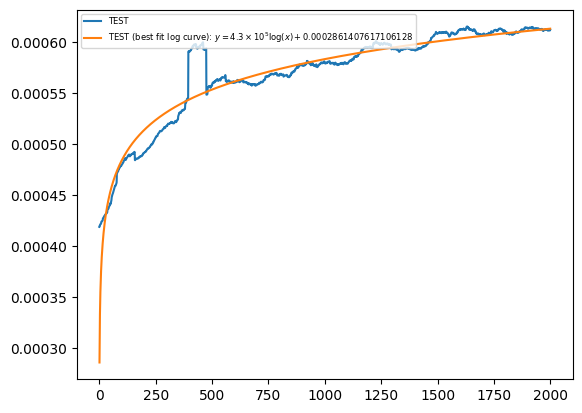

In [195]:
# ADD YOUR TEST CODE HERE 

framework = ExperimentalFramework(min_n=0, max_n=2000)

times = framework.insertion_test(LLRBBST, tree_ordering=RANDOM,
                                    new_element_ordering=RANDOM, num_of_tests=50, smooth_with_window_size=80)

framework.plot_times(plot_log_curve_of_best_fit=True, TEST=times)
